# Dog vs Cat Convolution Neural Network Classifier

### Problem Statement
Implementing a Convolution Neural Network (CNN) Classifier for classifying dog and cat images using TensorFlow/Keras.

### Architecture
- **Conv2D** → MaxPooling → **Conv2D** → MaxPooling → Flatten → Dense → **Sigmoid Output**

### Network Parameters
- Activation: ReLU (hidden layers), Sigmoid (output)
- Optimizer: Adam
- Loss: Binary CrossEntropy
- Input Shape: (64, 64, 3)

## Step 1: Install & Import Libraries

In [1]:
!pip install tensorflow-datasets seaborn scikit-learn -q

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from warnings import filterwarnings
filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('TensorFlow version:', tf.__version__)
print('GPU:', tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 2: Load Dataset
Using TensorFlow Datasets - downloads automatically, no Kaggle account needed!

In [2]:
(train_raw, val_raw, test_raw), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

print('Dataset loaded successfully!')
print(f'Total training examples: {info.splits["train"].num_examples}')
print(f'Classes: {info.features["label"].names}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.H4YI6H_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset loaded successfully!
Total training examples: 23262
Classes: ['cat', 'dog']


## Step 3: Data Preprocessing & Augmentation
- Rescale images to 0-1 range
- Resize to 64x64
- Apply augmentation: horizontal flip, zoom, shear

In [3]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Data Augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.1),
])

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label

train_ds = train_raw.map(preprocess).map(augment).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = val_raw.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds  = test_raw.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print('Train dataset ready!')
print('Validation dataset ready!')
print('Test dataset ready!')

Train dataset ready!
Validation dataset ready!
Test dataset ready!


## Step 4: Visualize Sample Images

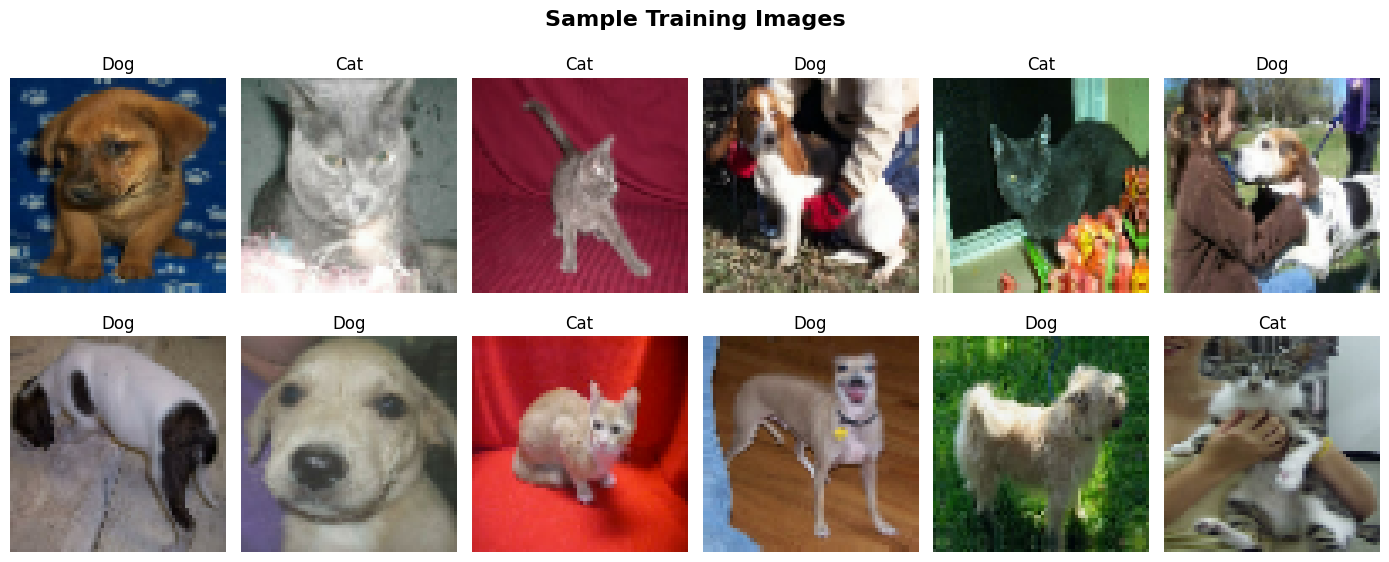

In [4]:
class_names = ['Cat', 'Dog']

plt.figure(figsize=(14, 6))
for images, labels in train_ds.take(1):
    for i in range(12):
        plt.subplot(2, 6, i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]], fontsize=12)
        plt.axis('off')
plt.suptitle('Sample Training Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 5: Build CNN Model
Same architecture as the reference notebook

In [5]:
classifier = Sequential([
    # First Conv Block
    Conv2D(32, (3,3), input_shape=(64,64,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    # Second Conv Block
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),

    # Fully Connected Layers
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=1, activation='sigmoid')  # Binary output: Cat or Dog
])

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
classifier.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

classifier.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,058,977 (4.04 MB)

 Trainable params: 1,058,977 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Train the Model

In [6]:
EPOCHS = 10  # Increase to 20+ for better accuracy

history = classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

print('\nTraining Complete!')

Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.5766 - loss: 0.6757 - val_accuracy: 0.7046 - val_loss: 0.5814
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.6998 - loss: 0.5756 - val_accuracy: 0.7416 - val_loss: 0.5378
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.7302 - loss: 0.5387 - val_accuracy: 0.7489 - val_loss: 0.5057
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.7442 - loss: 0.5119 - val_accuracy: 0.7726 - val_loss: 0.4790
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.7772 - loss: 0.4757 - val_accuracy: 0.7820 - val_loss: 0.4596
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.7848 - loss: 0.4599 - val_accuracy: 0.7975 - val_loss: 0.4371
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.8002 - loss: 0.4342 - val_accuracy: 0.8074 - val_loss: 0.4271
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.8112 - loss: 0.4177 - 

## Step 7: Validation Curves (Accuracy & Loss)

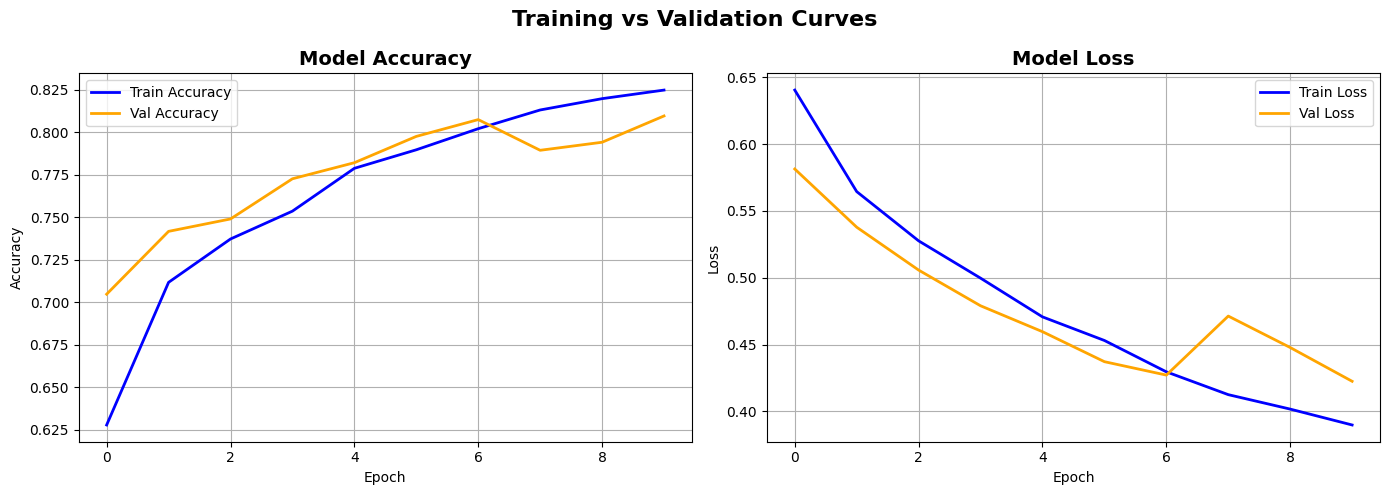

Validation curves saved!


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', color='orange', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss Plot
axes[1].plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', color='orange', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Training vs Validation Curves', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('validation_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('Validation curves saved!')

## Step 8: Confusion Matrix

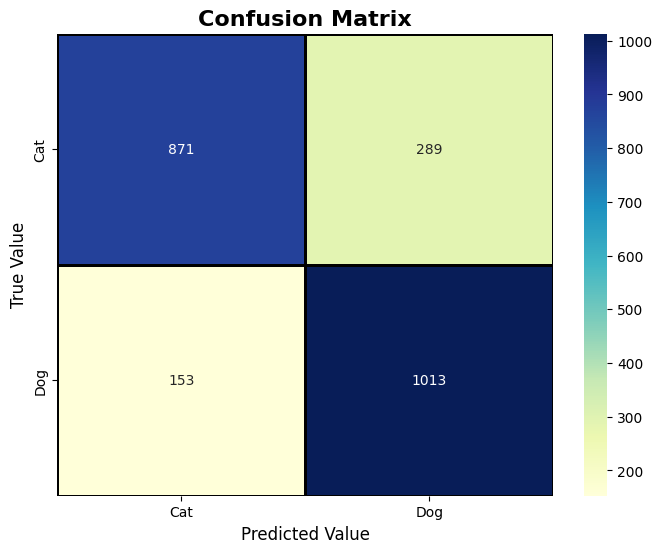

Confusion matrix saved!


In [8]:
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = classifier.predict(images, verbose=0)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu',
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'],
            linewidths=1, linecolor='black')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Value', fontsize=12)
plt.ylabel('True Value', fontsize=12)
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print('Confusion matrix saved!')

## Step 9: Model Evaluation

In [9]:
# Accuracy metrics
correct = np.sum(y_true == y_pred)
total = len(y_true)
accuracy = correct / total * 100

print('=' * 50)
print(f'Test Accuracy  : {accuracy:.2f}%')
print(f'Total Images   : {total}')
print(f'Correct        : {correct}')
print(f'Misclassified  : {total - correct}')
print('=' * 50)

print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

Test Accuracy  : 81.00%
Total Images   : 2326
Correct        : 1884
Misclassified  : 442

Classification Report:
              precision    recall  f1-score   support

         Cat       0.85      0.75      0.80      1160
         Dog       0.78      0.87      0.82      1166

    accuracy                           0.81      2326
   macro avg       0.81      0.81      0.81      2326
weighted avg       0.81      0.81      0.81      2326



## Step 10: Predict on Single Image

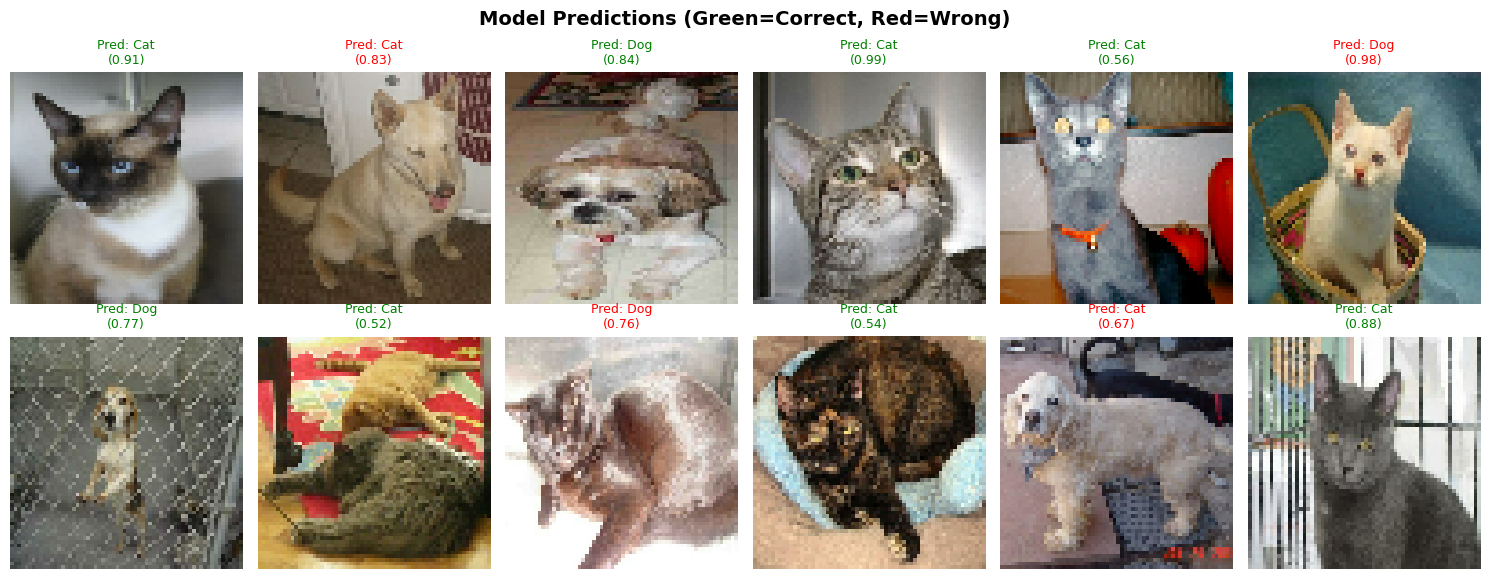

In [10]:
# Predict a random image from test set
class_names = ['Cat', 'Dog']

plt.figure(figsize=(15, 6))
count = 0
for images, labels in test_ds.take(1):
    for i in range(min(12, len(images))):
        img = images[i:i+1]
        pred = classifier.predict(img, verbose=0)[0][0]
        pred_label = 'Dog' if pred > 0.5 else 'Cat'
        true_label = class_names[labels[i].numpy()]
        confidence = pred if pred > 0.5 else 1 - pred

        plt.subplot(2, 6, i+1)
        plt.imshow(images[i])
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f'Pred: {pred_label}\n({confidence:.2f})', color=color, fontsize=9)
        plt.axis('off')

plt.suptitle('Model Predictions (Green=Correct, Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 11: Visualize CNN Layer Outputs

In [12]:
from tensorflow.keras.models import Model
import tensorflow as tf

# Get one sample image first
sample_img = None
for images, labels in test_ds.take(1):
    sample_img = images[0:1]
    break

# Build intermediate models by re-tracing layers with explicit Input
inputs = tf.keras.Input(shape=(64, 64, 3))
x = inputs
conv1_out = None
conv2_out = None
conv_count = 0

for layer in classifier.layers:
    x = layer(x)
    if 'conv2d' in layer.name:
        conv_count += 1
        if conv_count == 1:
            conv1_out = x
        elif conv_count == 2:
            conv2_out = x

conv1_model = Model(inputs=inputs, outputs=conv1_out)
conv2_model = Model(inputs=inputs, outputs=conv2_out)

conv1_features = conv1_model.predict(sample_img, verbose=0)
conv2_features = conv2_model.predict(sample_img, verbose=0)
print('Conv1 output shape:', conv1_features.shape)
print('Conv2 output shape:', conv2_features.shape)

Conv1 output shape: (1, 64, 64, 32)
Conv2 output shape: (1, 32, 32, 32)


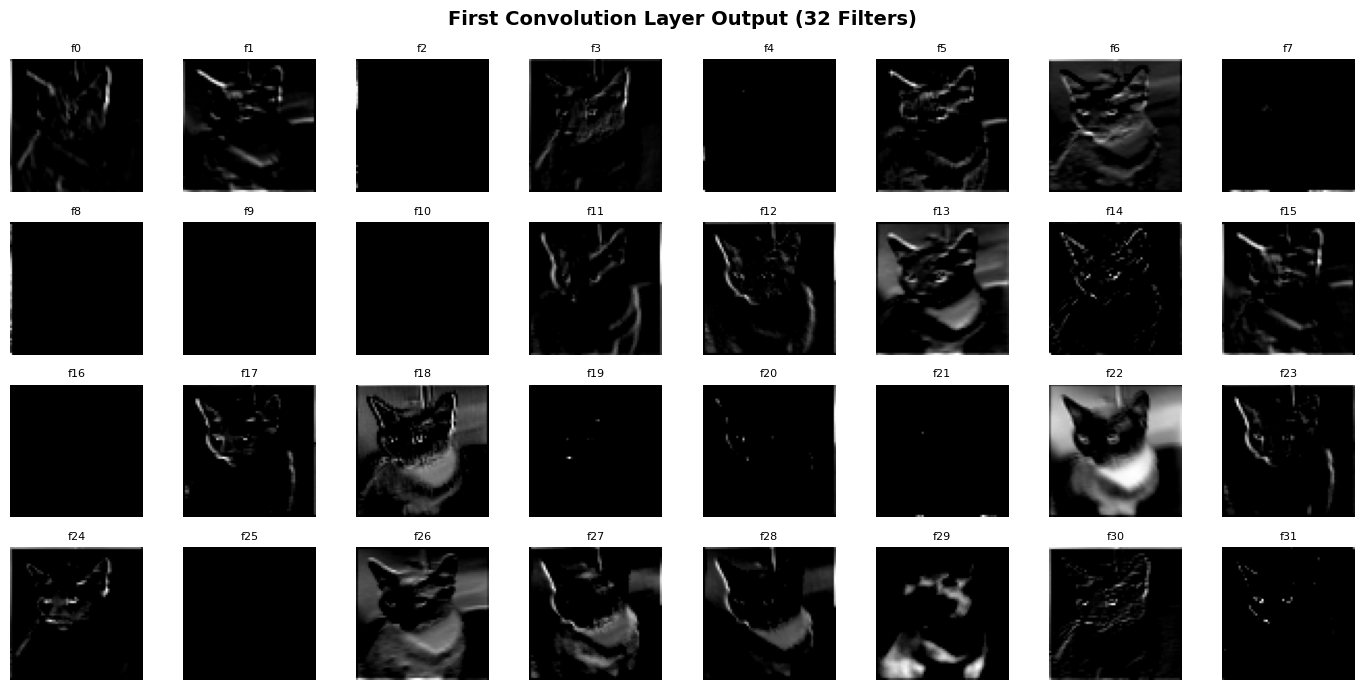

Conv1 filters visualized successfully!


In [13]:
# Visualize First Convolution Layer Filters
import matplotlib.pyplot as plt

# Safety check
if conv1_features is None:
    print("Error: Run the previous cell first!")
else:
    fig = plt.figure(figsize=(14, 7))
    columns, rows = 8, 4
    num_filters = min(columns * rows, conv1_features.shape[-1])

    for i in range(num_filters):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.axis('off')
        ax.set_title('f'+str(i), fontsize=8)
        ax.imshow(conv1_features[0, :, :, i], cmap='gray')

    plt.suptitle('First Convolution Layer Output (32 Filters)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('conv1_features.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Conv1 filters visualized successfully!")

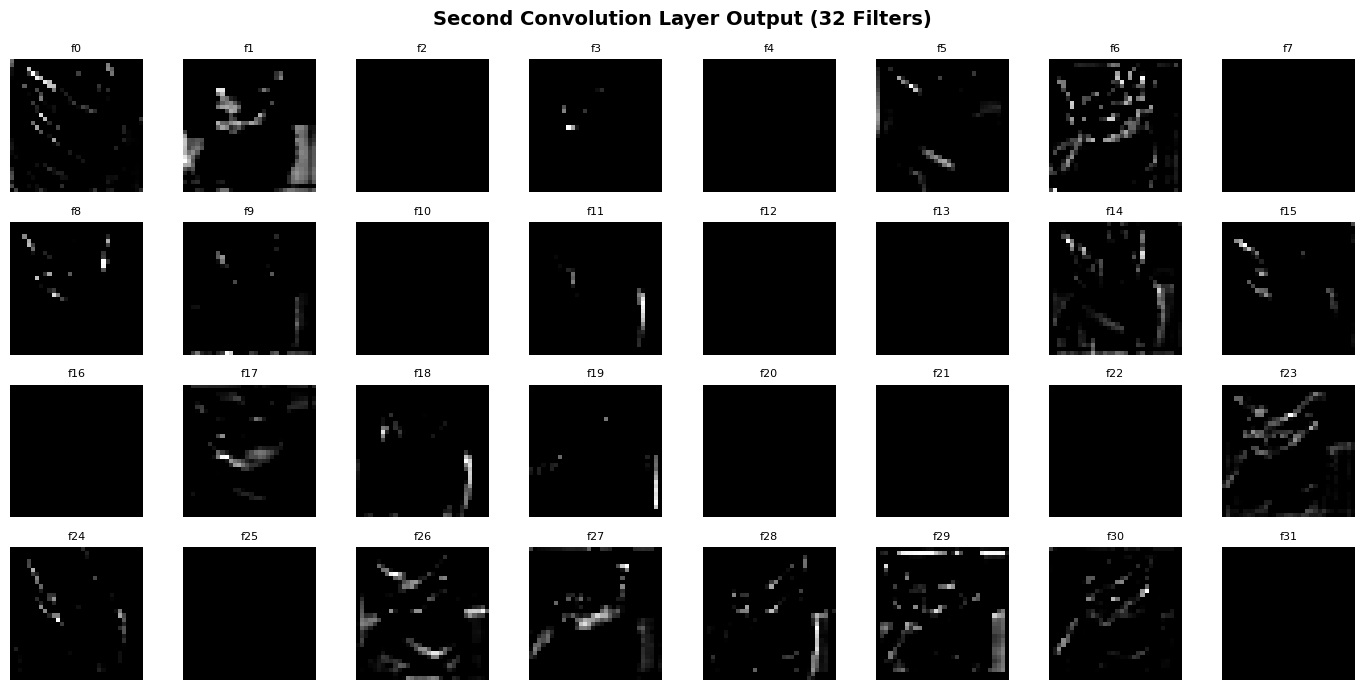

Conv2 filters visualized successfully!


In [14]:
# Visualize Second Convolution Layer Filters
fig = plt.figure(figsize=(14, 7))
columns, rows = 8, 4
num_filters = min(columns * rows, conv2_features.shape[-1])

for i in range(num_filters):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.axis('off')
    ax.set_title('f'+str(i), fontsize=8)
    ax.imshow(conv2_features[0, :, :, i], cmap='gray')

plt.suptitle('Second Convolution Layer Output (32 Filters)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('conv2_features.png', dpi=150, bbox_inches='tight')
plt.show()
print("Conv2 filters visualized successfully!")

## Step 12: Save the Model

In [15]:
classifier.save('dogcat_model.h5')
print('Model saved as dogcat_model.h5')

# Download the model
from google.colab import files
files.download('dogcat_model.h5')
files.download('validation_curves.png')
files.download('confusion_matrix.png')
print('All files downloaded!')

Model saved as dogcat_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All files downloaded!


## Conclusion

Successfully built and trained a CNN to classify Dogs vs Cats images.

**Key Learning Outcomes:**
- ✅ Data generators & augmentation (flip, zoom, shear)
- ✅ CNN architecture (Conv2D, MaxPooling, Flatten, Dense)
- ✅ Model fitting with validation
- ✅ Validation curves (accuracy & loss)
- ✅ Confusion matrix
- ✅ Layer output visualization

**Real-World Applications:** Visual quality checks, pet classifiers, intro to computer vision